# Model Inversion attack
The past few years have seen an explosion of machine learning models to applied to all areas of industry.
But just how much thought is given to security and safety of a model and the data upon which it's trained?
There are a myriad of ways that a model and its data can be compromised.
In this tutorial,
we will be running a simple **model inversion attack** on a classifier trained on MNIST.

## What is model inversion?
The aim of a model inversion attack is to recreate some data which was input to the model.
If such an attack is successful,
the consequences for a model or data holder could be disastrous,
for their reputation
and the possible legal liability of failing to adequately protect data.

## How to we do it?
Let's say there is an externally hosted,
trained model we wish to attack (the **target model**).
As we don't have a copy of the model,
we don't have any knowledge of the model parameters which we can utilise.
The best we can do is query the model by sending data to it to be classified.
This type of attack setting is known as **black box**,
because we know nothing about what's going on inside the model.

What we want to do is to train our own model
(the **attack model**)
which takes some output from the target model
and recreates the data which was fed to it.
Our attack model is essentially performing the same role as a _decoder_ in an autoencoder,
except in our case the _encoder_
(the target model)
has already been trained.

As we can query the target with our own data,
we can easily create a dataset of (target input, target output) data on which to train our attack model.
But what should this data look like?
If our target input data is too dissimilar to the data on which the target has been trained (for example, images of dogs applied to a model which classifies human faces),
it is likely that the data will be encoded into some small,
obscure part of the target's output space.
When we run the attack on data more typical of the target's intended task,
our attack model will not have learned how to turn output relating to a human face back into the human face.
Therefore,
we want our attacker training dataset to be _as close to the target training data_ as possible,
however we do not need to use actual training data.
In practice,
we can use our knowledge about the task a model has been trained to complete to find data which may look like its training data.

In this tutorial,
let's consider the case of a model which is distributed across multiple parties:
the first half of the model is located on one device;
this model part performs some inference on the data
and sends its output to the second device,
where the inference is finished.
This paradigm is increasingly common for models which run on mobile devices,
as output from a model layer can be smaller than the input data and therefore easier to send to a central server;
you may also recognise this process from [SplitNN](https://github.com/OpenMined/PySyft/tree/master/examples/tutorials/advanced/Split%20Neural%20Network),
a technique which preserves some data privacy
as raw data does not need to be sent to an untrusted party.

## Tutorial
In this tutorial we:
* Train a simple convolutional neural network (CNN), split into two parts, to classify images of handwritten digits (the MNIST dataset)
* Train an attack model to invert output of the first part of the model back into images of handwritten digits
* Run our attack model on unseen images

Authors:
* Tom Titcombe - Github: [@TTitcombe](https://github.com/TTitcombe)

In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST, MNIST
from tqdm.notebook import tqdm, trange

In [2]:
%matplotlib inline

#### Define hyperparameters for training the target model and the attack model.

In [3]:
hyperparams = namedtuple('hyperparams', 'batch_size,epochs,learning_rate,n_data')

# Target model hyperparameters
target_hyperparams = hyperparams(
    batch_size=256,
    epochs=10,
    learning_rate=1e-4,
    n_data=20_000,  # We don't need all the training data to get a decent MNIST classifier
)

# Attack model hyperparameters
attacker_hyperparams = hyperparams(
    batch_size=32,
    epochs=10,
    learning_rate=1e-4,
    n_data=500,
)

In [25]:
mnist_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),]
)

# Target model training data
train_data = MNIST("mnist", train=True, download=True, transform=mnist_transform)

# We don't need to use all the training data for MNIST as it's a simple dataset
train_data.data = train_data.data[:target_hyperparams.n_data]
train_data.targets = train_data.targets[:target_hyperparams.n_data]

# Target model test data
test_data = MNIST("mnist", train=False, download=True, transform=mnist_transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=target_hyperparams.batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1_000)

Extracting mnist\MNIST\raw\train-images-idx3-ubyte.gz to mnist\MNIST\raw


Extracting mnist\MNIST\raw\train-labels-idx1-ubyte.gz to mnist\MNIST\raw


Extracting mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist\MNIST\raw


Extracting mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist\MNIST\raw
Processing...
Done!


# Create a basic classifier
MNIST is not a complex dataset, so we do not need a large model. We create a single model for the purposes of this tutorial, but split the computation into two separate stages. In practice, the two stages would be hosted on different devices and the output of one stage would be communicated to the second device.

In [26]:
class Classifier(torch.nn.Module):
    def __init__(self, first_network, second_network) -> None:
        super().__init__()

        # --- First stage --- #
        self.stage1 = first_network
        
        # --- Second stage --- #
        # In practice, at this point the output of the previous stage would be transmitted to
        # a central server, where inference would continue
        self.stage2 = second_network

    def mobile_stage(self, x):
        return self.stage1(x)

    def forward(self, x):
        out = self.mobile_stage(x)
        out = out.view(out.size(0), -1)

        return self.stage2(out)

In [27]:
# The first part of the network. This would be hosted on a mobile device
first_network = torch.nn.Sequential(
            *[
                torch.nn.Conv2d(1, 32, kernel_size=5, padding=0, stride=1),  # first Conv layer
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.Conv2d(32, 32, kernel_size=5, padding=0, stride=1),  # second Conv layer
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
            ]
        )


# The second and final part of the network. This would be typically hosted on a central server in practice
second_network = torch.nn.Sequential(
            *[
                torch.nn.Linear(512, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 10),  # 10-class output
                torch.nn.Softmax(dim=-1),
            ]
        )

target_model = Classifier(first_network, second_network)
target_model

Classifier(
  (stage1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
    (3): Softmax(dim=-1)
  )
)

#### Train target model

In [7]:
optim = torch.optim.Adam(target_model.parameters(), lr=target_hyperparams.learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(target_hyperparams.epochs):
    train_correct = 0
    train_loss = 0.

    # Training loop
    for data, targets in train_loader:
        optim.zero_grad()

        output = target_model(data)

        # Update network
        loss = loss_criterion(output, targets)
        loss.backward()
        optim.step()

        # Track training statistics
        _, predicted = output.max(1)
        train_correct += predicted.eq(targets).sum().item()
        train_loss += loss.item()

train_loss /= len(train_data)

# Check test accuracy
test_correct = 0
test_loss = 0.

for data, targets in test_loader:
    with torch.no_grad():
        output = target_model(data)

    loss = loss_criterion(output, targets)

    _, predicted = output.max(1)
    test_correct += predicted.eq(targets).sum().item()
    test_loss += loss.item()

test_loss /= len(test_data)

print(
    f"Training loss: {train_loss:.3f}\n"
    f"Test loss: {test_loss:.3f}"
)

print(
    f"Training accuracy: {100 * train_correct / target_hyperparams.n_data:.3f}\n"
    f"Test accuracy: {100 * test_correct / len(test_data):.3f}"
)


Training loss: 0.006
Test loss: 0.002
Training accuracy: 95.775
Test accuracy: 96.140


---
# Attacking the target
You will notice that our attack model,
below,
is made up a deconvolutional layers.
This leverages our additional knowledge that the input data are images,
however this attack can work with other types of layers.

In [19]:
class AttackModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
            *[
                torch.nn.ConvTranspose2d(
                    in_channels=32,
                    out_channels=32,
                    kernel_size=7,
                    padding=1,
                    stride=2,
                    output_padding=1,
                ),
                torch.nn.ReLU(),
                torch.nn.ConvTranspose2d(
                    in_channels=32,
                    out_channels=32,
                    kernel_size=5,
                    padding=1,
                    stride=2,
                    output_padding=1,
                ),
                torch.nn.ReLU(),
                torch.nn.ConvTranspose2d(
                    in_channels=32, out_channels=1, kernel_size=5, padding=1, stride=1,
                ),
            ]
        )

    def forward(self, x):
        return self.layers(x)

#### Train the attack model
We may not know _exactly_ what the training data looked like,
but perhaps we find out that the engineers used a dataset of some kind of handwriting.
With this knowledge,
we can use the
[`EMNIST`](https://www.nist.gov/itl/products-and-services/emnist-dataset)
dataset of handwritten letters to create our attack dataset;
hopefully the images in this dataset are similar enough to the target's training data
that the attack will still be successful.

In [21]:
# Get attacker
attacker = AttackModel()

# Get dataset
attacker_dataset = EMNIST("emnist", "letters", download=True, train=False, transform=mnist_transform)

# Use the last n_data images in the test set to train the attacker
attacker_dataset.data = attacker_dataset.data[:attacker_hyperparams.n_data]
attacker_dataset.targets = attacker_dataset.targets[:attacker_hyperparams.n_data]

attacker_train_loader = torch.utils.data.DataLoader(attacker_dataset, batch_size=attacker_hyperparams.batch_size)

# Train attacker
attack_optim = torch.optim.Adam(attacker.parameters(), lr=attacker_hyperparams.learning_rate)

for epoch in trange(attacker_hyperparams.epochs):
    for data, targets in attacker_train_loader:
        data.float()
        targets.float()

        attack_optim.zero_grad()

        # We intercept the output of the mobile device's model
        # This is the input of our attack model
        with torch.no_grad():
            attack_input = target_model.mobile_stage(data)

        output = attacker(attack_input)

        loss = ((output - data)**2).mean()  # We want our reconstructed image to look as much like the original image as possible
        loss.backward()
        attack_optim.step()

#### Attack the target
With our attack model trained,
we can extract images from the target model.
The next time somebody uses the target,
we will intercept the output of the first model stage
and hopefully be able to generate our victim's data.

In [22]:
def plot_images(
    tensors,
):
    """
    Plot normalised MNIST tensors as images
    """
    fig = plt.figure(figsize=(10, 5))

    n_tensors = len(tensors)
    n_cols = min(n_tensors, 4)
    n_rows = int((n_tensors - 1) / 4) + 1

    # De-normalise an MNIST tensor
    mu = torch.tensor([0.1307], dtype=torch.float32)
    sigma = torch.tensor([0.3081], dtype=torch.float32)
    Unnormalise = transforms.Normalize((-mu / sigma).tolist(), (1.0 / sigma).tolist())

    for row in range(n_rows):
        for col in range(n_cols):
            idx = n_cols * row + col

            if idx > n_tensors - 1:
                break

            ax = fig.add_subplot(n_rows, n_cols, idx + 1)
            tensor = Unnormalise(tensors[idx])

            # Clip image values so we can plot
            tensor[tensor < 0] = 0
            tensor[tensor > 1] = 1

            tensor = tensor.squeeze(0)  # remove batch dim

            ax.imshow(transforms.ToPILImage()(tensor), interpolation="bicubic")

    plt.tight_layout()
    plt.show()

In [23]:
def attack(attack_model, target_model, dataset, idxs):
    images = []

    for datum_idx in idxs:
        actual_image, _ = dataset[datum_idx]

        with torch.no_grad():
            target_output = target_model.mobile_stage(actual_image.unsqueeze(0))
            reconstructed_image = attack_model(target_output).squeeze(0)

        images.append(actual_image)
        images.append(reconstructed_image)

    plot_images(images)

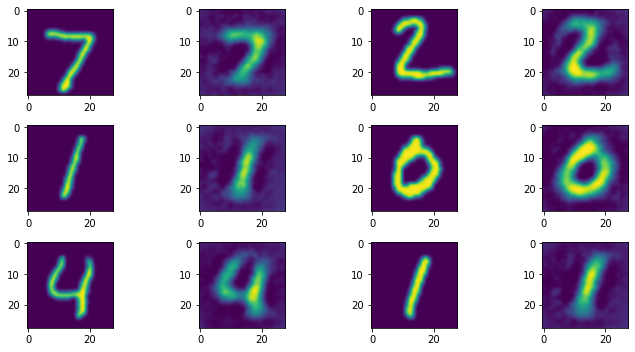

In [24]:
attack(attacker, target_model, test_data, range(6))

You can see that we have successfully recreated the input images
without having access to any training data.
While handwritten digits are not the most private of data,
this attack would have worked equally well on a model to classify faces
or MRI results.

## Extension
* Try to invert output from layers deeper into the target model as well as the classification probabilities. What do you notice about an attacker's capacity to invert data?
* Consider simple, practical steps that can be taken to protect a model from a model inversion attack. In particular, what could be done to the model, and to the way in which the model is exposed to the world? 